# Drill: Introduction to Scrapping -- Kristofer Schobert

In this notebook, we follow along with Thinkful's lessons on scrapping data from webpages. We are introduced to the package Scrapy as well as the use of APIs. 

This is very rough work. Most of it is uneditted. 

In [1]:
# Importing in each cell because of the kernel restarts.
import scrapy
from scrapy.crawler import CrawlerProcess


class ESSpider(scrapy.Spider):
    # Naming the spider is important if you are running more than one spider of
    # this class simultaneously.
    name = "ESS"
    
    # URL(s) to start with.
    start_urls = [
        'http://www.everydaysexism.com',
    ]

    # What to do with the URL.  Here, we tell it to download all the code and save
    # it to the mainpage.html file
    def parse(self, response):
        with open('mainpage.html', 'wb') as f:
            f.write(response.body)


# Instantiate our crawler.
process = CrawlerProcess()

# Start the crawler with our spider.
process.crawl(ESSpider)
process.start()

2019-05-07 11:36:45 [scrapy.utils.log] INFO: Scrapy 1.6.0 started (bot: scrapybot)
2019-05-07 11:36:45 [scrapy.utils.log] INFO: Versions: lxml 4.3.3.0, libxml2 2.9.9, cssselect 1.0.3, parsel 1.5.1, w3lib 1.20.0, Twisted 19.2.0, Python 3.7.2 (default, Dec 29 2018, 00:00:04) - [Clang 4.0.1 (tags/RELEASE_401/final)], pyOpenSSL 19.0.0 (OpenSSL 1.1.1b  26 Feb 2019), cryptography 2.6.1, Platform Darwin-18.0.0-x86_64-i386-64bit
2019-05-07 11:36:45 [scrapy.crawler] INFO: Overridden settings: {}
2019-05-07 11:36:45 [scrapy.extensions.telnet] INFO: Telnet Password: d6a1f4a1259ee2ff
2019-05-07 11:36:45 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.memusage.MemoryUsage',
 'scrapy.extensions.logstats.LogStats']
2019-05-07 11:36:45 [scrapy.middleware] INFO: Enabled downloader middlewares:
['scrapy.downloadermiddlewares.httpauth.HttpAuthMiddleware',
 'scrapy.downloadermiddlewares.downloadtimeout.D

In [1]:
# Importing in each cell because of the kernel restarts.
import scrapy
from scrapy.crawler import CrawlerProcess


class ESSpider(scrapy.Spider):
    # Naming the spider is important if you are running more than one spider of
    # this class simultaneously.
    name = "ESS"
    
    # URL(s) to start with.
    start_urls = [
        'http://www.everydaysexism.com',
    ]

    # Use XPath to parse the response we get.
    def parse(self, response):
        
        # Iterate over every <article> element on the page.
        for article in response.xpath('//article'):
            
            # Yield a dictionary with the values we want.
            yield {
                # This is the code to choose what we want to extract
                # You can modify this with other Xpath expressions to extract other information from the site
                'name': article.xpath('header/h2/a/@title').extract_first(),
                'date': article.xpath('header/section/span[@class="entry-date"]/text()').extract_first(),
                'text': article.xpath('section[@class="entry-content"]/p/text()').extract(),
                'tags': article.xpath('*/span[@class="tag-links"]/a/text()').extract()
            }

# Tell the script how to run the crawler by passing in settings.
process = CrawlerProcess({
    'FEED_FORMAT': 'json',         # Store data in JSON format.
    'FEED_URI': 'firstpage.json',  # Name our storage file.
    'LOG_ENABLED': False           # Turn off logging for now.
})

# Start the crawler with our spider.
process.crawl(ESSpider)
process.start()
print('Success!')


Success!


In [3]:
import pandas as pd

firstpage = pd.read_json('firstpage.json', orient='records')
print(firstpage.shape)
firstpage.head()

(10, 4)


,date,name,tags,text
0,2019-05-03,Veronica,[Home],[My brother says that there should be an All M...
1,2019-05-03,Zara,[Public space],[When I was fifteen I went skating with my sis...
2,2019-05-03,Zara,"[Public space, University]","[Two stories in different places, but they hap..."
3,2019-05-03,"Veronika Didusenko, Miss Ukraine 2018","[Media, missuniverse, missworld, singlemoms, W...",[I am a professional model and have been walki...
4,2019-05-03,Kelly,"[Friendships, Home, Public space, Workplace]",[I got called the mother of the business as on...


In [1]:
# Importing in each cell because of the kernel restarts.
import scrapy
import re
from scrapy.crawler import CrawlerProcess

class ESSpider(scrapy.Spider):
    # Naming the spider is important if you are running more than one spider of
    # this class simultaneously.
    name = "ESS"
    
    # URL(s) to start with.
    start_urls = [
        'http://www.everydaysexism.com',
    ]

    # Use XPath to parse the response we get.
    def parse(self, response):
        
        # Iterate over every <article> element on the page.
        for article in response.xpath('//article'):
            
            # Yield a dictionary with the values we want.
            yield {
                'name': article.xpath('header/h2/a/@title').extract_first(),
                'date': article.xpath('header/section/span[@class="entry-date"]/text()').extract_first(),
                'text': article.xpath('section[@class="entry-content"]/p/text()').extract(),
                'tags': article.xpath('*/span[@class="tag-links"]/a/text()').extract()
            }
        # Get the URL of the previous page.
        next_page = response.xpath('//div[@class="nav-previous"]/a/@href').extract_first()
        
        # There are a LOT of pages here.  For our example, we'll just scrape the first 9.
        # This finds the page number. The next segment of code prevents us from going beyond page 9.
        pagenum = int(re.findall(r'\d+',next_page)[0])
        
        # Recursively call the spider to run on the next page, if it exists.
        if next_page is not None and pagenum < 10:
            next_page = response.urljoin(next_page)
            # Request the next page and recursively parse it the same way we did above
            yield scrapy.Request(next_page, callback=self.parse)

# Tell the script how to run the crawler by passing in settings.
# The new settings have to do with scraping etiquette.          
process = CrawlerProcess({
    'FEED_FORMAT': 'json',         # Store data in JSON format.
    'FEED_URI': 'data.json',       # Name our storage file.
    'LOG_ENABLED': False,          # Turn off logging for now.
    'ROBOTSTXT_OBEY': True,
    'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
    'AUTOTHROTTLE_ENABLED': True,
    'HTTPCACHE_ENABLED': True
})

# Start the crawler with our spider.
process.crawl(ESSpider)
process.start()
print('Success!')

Success!


In [9]:
import pandas as pd

# Checking whether we got data from all 9 pages
ESSdf=pd.read_json('data.json', orient='records')
print(ESSdf.shape)
ESSdf

(90, 4)


,date,name,tags,text
0,2019-05-03,Veronica,[Home],[My brother says that there should be an All M...
1,2019-05-03,Zara,[Public space],[When I was fifteen I went skating with my sis...
2,2019-05-03,Zara,"[Public space, University]","[Two stories in different places, but they hap..."
3,2019-05-03,"Veronika Didusenko, Miss Ukraine 2018","[Media, missuniverse, missworld, singlemoms, W...",[I am a professional model and have been walki...
4,2019-05-03,Kelly,"[Friendships, Home, Public space, Workplace]",[I got called the mother of the business as on...
5,2019-05-03,Nora,[Public space],[There is a means of condescending to someone ...
6,2019-05-03,alice,[University],[This guy told me his idea of dating advice th...
7,2019-05-03,Hannah,"[Home, Public space, School, Stereotypes]",[For as long as I can remember I have broken e...
8,2019-05-03,Emily,[Friends social],[I was 13 when it started this boy who one of ...
9,2019-05-03,Libby,[Workplace],"[On my first day of working at a new job, I wa..."


In [1]:
import scrapy
from scrapy.crawler import CrawlerProcess


class WikiSpider(scrapy.Spider):
    name = "WS"
    
    # Here is where we insert our API call.
    start_urls = [
        'https://en.wikipedia.org/w/api.php?action=query&format=xml&prop=linkshere&titles=Monty_Python&lhprop=title%7Credirect'
        ]

    # Identifying the information we want from the query response and extracting it using xpath.
    def parse(self, response):
        for item in response.xpath('//lh'):
            # The ns code identifies the type of page the link comes from.  '0' means it is a Wikipedia entry.
            # Other codes indicate links from 'Talk' pages, etc.  Since we are only interested in entries, we filter:
            if item.xpath('@ns').extract_first() == '0':
                yield {
                    'title': item.xpath('@title').extract_first() 
                    }
        # Getting the information needed to continue to the next ten entries.
        next_page = response.xpath('continue/@lhcontinue').extract_first()
        
        # Recursively calling the spider to process the next ten entries, if they exist.
        if next_page is not None:
            next_page = '{}&lhcontinue={}'.format(self.start_urls[0],next_page)
            yield scrapy.Request(next_page, callback=self.parse)
            
    
process = CrawlerProcess({
    'FEED_FORMAT': 'json',
    'FEED_URI': 'PythonLinks.json',
    # Note that because we are doing API queries, the robots.txt file doesn't apply to us.
    'ROBOTSTXT_OBEY': False,
    'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
    'AUTOTHROTTLE_ENABLED': True,
    'HTTPCACHE_ENABLED': True,
    'LOG_ENABLED': False,
    # We use CLOSESPIDER_PAGECOUNT to limit our scraper to the first 100 links.    
    'CLOSESPIDER_PAGECOUNT' : 10
})
                                         

# Starting the crawler with our spider.
process.crawl(WikiSpider)
process.start()
print('First 100 links extracted!')

First 100 links extracted!


In [5]:
import pandas as pd

# Checking whether we got data 

Monty=pd.read_json('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/PythonLinks.json', orient='records')
print(Monty.shape)
Monty.head(34)

(92, 1)


,title
0,Beachcomber (pen name)
1,Bing Crosby
2,Bob Costas
3,Comedy film
4,List of comedians
5,Douglas Adams
6,David Bowie
7,Do Not Adjust Your Set
8,Elvis Presley
9,Ennio Morricone


# Gathering data on day length times from sunrise-sunset.org

In [1]:
import scrapy
import json
from scrapy.crawler import CrawlerProcess
from scrapy.loader import ItemLoader

class SunSpider(scrapy.Spider):
    name = "SS"
    
    # Here is where we insert our API call.
    start_urls = ['https://api.sunrise-sunset.org/json?lat='
                      + str(i + .01) + '&lng=-4.4203400>' for i in range(0,80,10)]

    def parse(self, response):
        # the files are returned in json format
        jsonresponse = json.loads(response.body_as_unicode())

        return jsonresponse['results']

process = CrawlerProcess({
    'FEED_FORMAT': 'json',
    'FEED_URI': 'sunrise_sunset.json'
})
                                         

# Starting the crawler with our spider.
process.crawl(SunSpider)
process.start()
print('Done!')

2019-05-09 23:29:03 [scrapy.utils.log] INFO: Scrapy 1.6.0 started (bot: scrapybot)
2019-05-09 23:29:03 [scrapy.utils.log] INFO: Versions: lxml 4.3.3.0, libxml2 2.9.9, cssselect 1.0.3, parsel 1.5.1, w3lib 1.20.0, Twisted 19.2.0, Python 3.7.2 (default, Dec 29 2018, 00:00:04) - [Clang 4.0.1 (tags/RELEASE_401/final)], pyOpenSSL 19.0.0 (OpenSSL 1.1.1b  26 Feb 2019), cryptography 2.6.1, Platform Darwin-18.0.0-x86_64-i386-64bit
2019-05-09 23:29:03 [scrapy.crawler] INFO: Overridden settings: {'FEED_FORMAT': 'json', 'FEED_URI': 'sunrise_sunset.json'}
2019-05-09 23:29:03 [scrapy.extensions.telnet] INFO: Telnet Password: e78bd46e8b36f718
2019-05-09 23:29:03 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.memusage.MemoryUsage',
 'scrapy.extensions.feedexport.FeedExporter',
 'scrapy.extensions.logstats.LogStats']
2019-05-09 23:29:04 [scrapy.middleware] INFO: Enabled downloader middlewares:
['scrap

2019-05-09 23:29:05 [scrapy.core.engine] INFO: Spider closed (finished)


Done!


In [4]:
# Scrapy lists data from webpages in the order of which webpage completed downloading first. 
# this is not the order start_urls page.

latitude_in_download_order = [0.01, 10.01, 20.01, 50.01, 40.01, 30.01, 60.01, 70.01]

In [5]:
# importing pandas
import pandas as pd

# creating a pandas dataframe of our json file 
sun_df=pd.read_json('sunrise_sunset.json', orient='records')
sun_df['latitude'] = latitude_in_download_order

2019-05-09 23:36:32 [matplotlib] DEBUG: $HOME=/Users/Kris
2019-05-09 23:36:32 [matplotlib] DEBUG: CONFIGDIR=/Users/Kris/.matplotlib
2019-05-09 23:36:32 [matplotlib] DEBUG: matplotlib data path: /anaconda3/envs/first_sandbox/lib/python3.7/site-packages/matplotlib/mpl-data
2019-05-09 23:36:32 [matplotlib] DEBUG: loaded rc file /anaconda3/envs/first_sandbox/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc
2019-05-09 23:36:32 [matplotlib] DEBUG: matplotlib version 3.0.3
2019-05-09 23:36:32 [matplotlib] DEBUG: interactive is False
2019-05-09 23:36:32 [matplotlib] DEBUG: platform is darwin
2019-05-09 23:36:32 [matplotlib] DEBUG: loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', 'zipimport', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_abc', '_bootlocale', '_locale', 'site', 'os', 'stat',

In [6]:
# viewing our dataframe
sun_df

,astronomical_twilight_begin,astronomical_twilight_end,civil_twilight_begin,civil_twilight_end,day_length,nautical_twilight_begin,nautical_twilight_end,solar_noon,sunrise,sunset,latitude
0,4:58:20 AM,7:29:49 PM,5:48:51 AM,6:39:18 PM,12:07:09,5:23:37 AM,7:04:32 PM,12:14:04 PM,6:10:30 AM,6:17:39 PM,0.01
1,4:43:15 AM,7:44:54 PM,5:35:24 AM,6:52:45 PM,12:33:09,5:09:28 AM,7:18:41 PM,12:14:04 PM,5:57:30 AM,6:30:39 PM,10.01
2,4:24:02 AM,8:04:07 PM,5:20:05 AM,7:08:04 PM,13:01:13,4:52:23 AM,7:35:46 PM,12:14:04 PM,5:43:28 AM,6:44:41 PM,20.01
3,2:04:16 AM,10:23:52 PM,3:59:55 AM,8:28:14 PM,15:11:35,3:09:23 AM,9:18:46 PM,12:14:04 PM,4:38:17 AM,7:49:52 PM,50.01
4,3:18:48 AM,9:09:21 PM,4:36:44 AM,7:51:25 PM,14:14:25,3:59:34 AM,8:28:35 PM,12:14:04 PM,5:06:52 AM,7:21:17 PM,40.01
5,3:57:57 AM,8:30:12 PM,5:01:26 AM,7:26:43 PM,13:33:39,4:30:25 AM,7:57:44 PM,12:14:04 PM,5:27:15 AM,7:00:54 PM,30.01
6,12:00:01 AM,12:00:01 AM,2:51:05 AM,9:37:04 PM,16:46:55,12:43:53 AM,11:44:16 PM,12:14:04 PM,3:50:37 AM,8:37:32 PM,60.01
7,12:00:01 AM,12:00:01 AM,12:00:01 AM,12:00:01 AM,21:02:05,12:00:01 AM,12:00:01 AM,12:14:04 PM,1:43:02 AM,10:45:07 PM,70.01


2019-05-09 23:48:05 [matplotlib.axes._base] DEBUG: update_title_pos
2019-05-09 23:48:05 [matplotlib.font_manager] DEBUG: findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/anaconda3/envs/first_sandbox/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
2019-05-09 23:48:05 [matplotlib.axes._base] DEBUG: update_title_pos
2019-05-09 23:48:05 [matplotlib.axes._base] DEBUG: update_title_pos
2019-05-09 23:48:05 [matplotlib.axes._base] DEBUG: update_title_pos


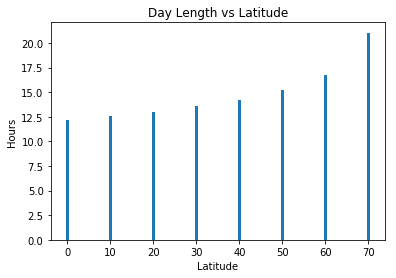

In [23]:
# plotting day-length versus latitude
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt

# getting day length into units of hours
day_length_hours = []
for time in sun_df['day_length']:
    day_length_hours.append(int(time[0:2]) + int(time[3:5])/60 + int(time[6:8])/3600)


plt.bar(height = list(day_length_hours), x = list(sun_df['latitude']))
plt.title('Day Length vs Latitude')
plt.xlabel('Latitude')
plt.ylabel('Hours')
plt.show()